# Классификация заявок по типу оборудования

Целью данного модуля является обучение модели машинного обучения на данных тренировочной выборки, расширенной с помощью синтетических данных и тестировании на оригинальных данных, которые не участвовали в генерации синтетических данных, чтобы выявить качество на самостоятельно выделенной тестовой выборка, а уже потом обучить модель на всех данных.

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import torch
import math
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn.functional as F
from torch import Tensor
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Input, Bidirectional, Dropout, BatchNormalization, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import tf2onnx
from keras.utils import plot_model
warnings.filterwarnings('ignore')

## Обучение на самостоятельно выделенной обучающей выборке.

Загрузим данные обучающей и тестовой выборок с добавленными в обучающую выборку синтетическими данными.

In [293]:
save_path_train = '../data/df_train_balanced_by_failure_point.csv'
save_path_test= '../data/df_2_test.csv'

In [294]:
df_train = pd.read_csv(save_path_train)
df_test = pd.read_csv(save_path_test)

Поскольку Тема и Описание могут быть в равной степени информативными для представления о типе оборудования, объединим их в одну колонку и будем воспринимать как текстовую информцию о проблеме.

In [174]:
df_train['Тема_Описание'] = df_train['Тема'] + ' ' + df_train['Описание']

df_train = df_train.drop(columns=['Тип оборудования', 'Серийный номер', 'Тема', 'Описание'])

df_train

Точка отказа                                      Тема_Описание
0                Корпус  СИЛА НК2-1404 // Погнутость крышки // С2230126...
1                  Диск  Неисправность диска Enclosure=6:Disk=32 dd202 ...
2          Блок питания  СИЛА НК2-1404// Замена ЗУ на ноутбуках Сила HK...
3          Блок питания  FW: Гарантийный случай Добрый день \r\n по одн...
4                Сервер  Неисправность сервера СИЛА // 46919 Коллеги, д...
..                  ...                                                ...
570  Оперативная память  Синий экран при загрузке При запуске системы в...
571                Диск  СИЛА НК2-1404 Прошу предоставить информацию о ...
572                Диск  СХД CX4-1127-00 Добрый день, коллеги. Прошу пр...
573                Диск  Открыть кейс по неисправности диска Доброго вр...
574       Wi-fi антенна         НК2-1404 Не могу подключиться к сети Wi-Fi

[575 rows x 2 columns]

Поскольку модель машинного обучения не может напрямую воспринимать текстовые данные, их требуется векторизовать.

В качестве алгоритма векторизации была выбрана модель "intfloat/multilingual-e5-large-instruct".

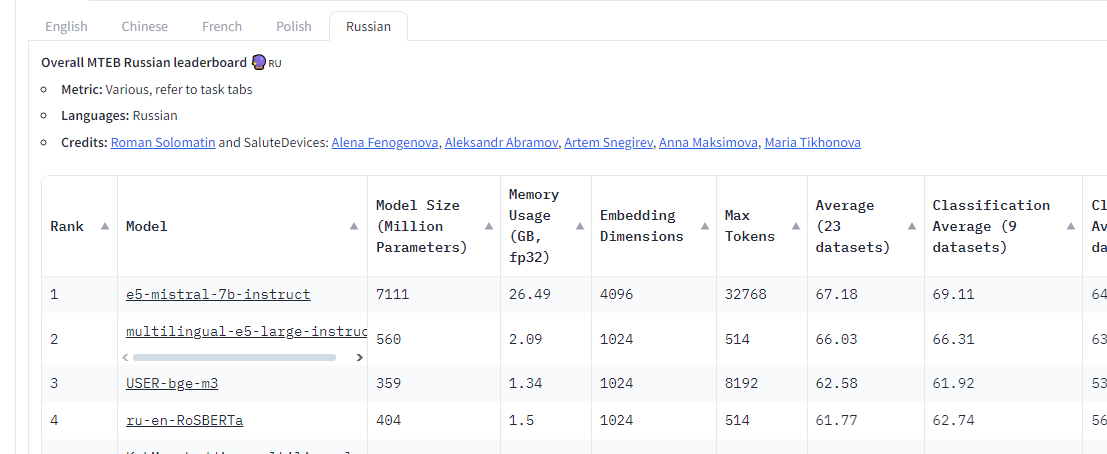

Согласно лидерборду моделей для векторизации текстов на русском языке, multilingual-e5-large-instruct является второй по качеству, однако первая по кчеству модель в 13 раз больше по размеру в сравнении с multilingual-e5-large-instruct, что может негативно сказаться на скорости при ее использовании.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

texts = df_train['Тема_Описание'].tolist()

batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**batch_dict)

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    ''' 
    Функция average_pool выполняет усреднение скрытых состояний последнего слоя модели, 
    учитывая маску внимания. 

    Параметры:
    - last_hidden_states: Тензор, содержащий скрытые состояния последнего слоя модели. 
      Размерность тензора - (batch_size, sequence_length, hidden_size).
    - attention_mask: Тензор, указывающий, какие токены следует учитывать при усреднении. 
      Размерность тензора - (batch_size, sequence_length).

    Возвращает:
    - Тензор, представляющий усредненные эмбеддинги для каждого примера в батче. 
      Размерность тензора - (batch_size, hidden_size).
    
    Процесс:
    1. Скрытые состояния, соответствующие токенам, которые не должны учитываться (например, паддинг), 
       заменяются на нули с помощью метода masked_fill.
    2. Затем выполняется суммирование скрытых состояний по временной оси (dim=1).
    3. Наконец, результат делится на количество токенов, которые были учтены (сумма маски внимания), 
       чтобы получить усредненные эмбеддинги.
    '''
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings = F.normalize(embeddings, p=2, dim=1)

In [176]:
embeddings_df = pd.DataFrame(embeddings.numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

df_train = pd.concat([df_train.drop(columns=['Тема_Описание']), embeddings_df], axis=1)

df_train

Точка отказа  embedding_0  embedding_1  embedding_2  embedding_3  \
0                Корпус    -0.002749     0.009215    -0.010355    -0.043586   
1                  Диск     0.010910     0.016301    -0.004598    -0.037258   
2          Блок питания     0.016026     0.015640    -0.024150    -0.039584   
3          Блок питания     0.000323     0.014567    -0.023428    -0.051470   
4                Сервер     0.015421     0.001804    -0.021872    -0.032377   
..                  ...          ...          ...          ...          ...   
570  Оперативная память     0.034789     0.014841    -0.018975    -0.044588   
571                Диск     0.018810     0.011810    -0.013581    -0.045287   
572                Диск     0.035147     0.010280    -0.025957    -0.062596   
573                Диск     0.018924    -0.027290     0.007641    -0.026643   
574       Wi-fi антенна    -0.008895     0.036481     0.002293    -0.054522   

     embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  ...  \
0       0.030239    -0.006040    -0.025965     0.098178     0.023867  ...   
1       0.033857    -0.015950    -0.043913     0.111341     0.053975  ...   
2       0.042094    -0.018102    -0.016622     0.083976     0.043547  ...   
3       0.033223    -0.017523    -0.018672     0.094544     0.043758  ...   
4       0.020156    -0.038345    -0.029341     0.089646     0.051678  ...   
..           ...          ...          ...          ...          ...  ...   
570     0.026131     0.000843    -0.042328     0.104719     0.045450  ...   
571     0.026192     0.010277    -0.035004     0.079476     0.059381  ...   
572     0.013435    -0.029378    -0.016315     0.090488     0.035857  ...   
573     0.018423     0.018773    -0.024370     0.079731     0.052483  ...   
574     0.015879     0.025071    -0.029118     0.081627     0.025768  ...   

     embedding_1014  embedding_1015  embedding_1016  embedding_1017  \
0         -0.032898       -0.028066        0.001805       -0.030957   
1          0.005677       -0.024711       -0.012773       -0.002875   
2         -0.014764       -0.051549       -0.018228       -0.009036   
3         -0.003642       -0.039863       -0.007806       -0.007334   
4         -0.009021       -0.036557       -0.000237       -0.006494   
..              ...             ...             ...             ...   
570        0.004931       -0.026351       -0.014647        0.024129   
571       -0.017321       -0.057973        0.010091       -0.020271   
572       -0.017143       -0.030076       -0.012913       -0.005361   
573       -0.020560       -0.039537        0.001228       -0.009546   
574       -0.005036       -0.050265       -0.003507       -0.019913   

     embedding_1018  embedding_1019  embedding_1020  embedding_1021  \
0          0.006313        0.040716        0.016736       -0.017238   
1         -0.004472        0.041322        0.046584       -0.016264   
2          0.002136        0.029653        0.038954       -0.023911   
3          0.002879        0.047988        0.030287       -0.027121   
4          0.002631        0.016490        0.031496       -0.009221   
..              ...             ...             ...             ...   
570        0.014849        0.032283        0.031402       -0.015548   
571        0.012634        0.030567        0.022471       -0.041506   
572       -0.001373        0.024653        0.016816       -0.030576   
573       -0.001885        0.035753        0.015844       -0.039826   
574        0.018586        0.051689        0.016037       -0.028617   

     embedding_1022  embedding_1023  
0         -0.039312        0.024163  
1         -0.051200        0.008428  
2         -0.042132        0.028792  
3         -0.068433        0.013932  
4         -0.041884        0.017914  
..              ...             ...  
570       -0.009493       -0.013870  
571       -0.057375        0.025053  
572       -0.049782        0.033414  
573       -0.043607        0.004933  
574       -0.

Сохраним полученный датасет с эмбедингами

In [177]:
df_train.to_csv('../data/df_train_balanced_failure_point_embeded.csv', index=False)

In [ ]:
# df_train = pd.read_csv('../data/df_train_balanced_failure_point_embeded.csv')

Поскольку в датасете на скрытой выборке не будет класса "Консультация", то избавимся от всех объектов, которые его содержат

In [307]:
df_train = df_train[df_train['Точка отказа'] != 'Консультация']

df_train

Точка отказа  embedding_0  embedding_1  embedding_2  embedding_3  \
0                Корпус    -0.002749     0.009215    -0.010355    -0.043586   
1                  Диск     0.010910     0.016301    -0.004598    -0.037258   
2          Блок питания     0.016026     0.015640    -0.024150    -0.039584   
3          Блок питания     0.000323     0.014567    -0.023428    -0.051470   
4                Сервер     0.015421     0.001804    -0.021872    -0.032377   
..                  ...          ...          ...          ...          ...   
570  Оперативная память     0.034789     0.014841    -0.018975    -0.044588   
571                Диск     0.018810     0.011810    -0.013581    -0.045287   
572                Диск     0.035147     0.010280    -0.025957    -0.062596   
573                Диск     0.018924    -0.027290     0.007641    -0.026643   
574       Wi-fi антенна    -0.008895     0.036481     0.002293    -0.054522   

     embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  ...  \
0       0.030239    -0.006040    -0.025965     0.098178     0.023867  ...   
1       0.033857    -0.015950    -0.043913     0.111341     0.053975  ...   
2       0.042094    -0.018102    -0.016622     0.083976     0.043547  ...   
3       0.033223    -0.017522    -0.018672     0.094544     0.043758  ...   
4       0.020156    -0.038345    -0.029341     0.089646     0.051678  ...   
..           ...          ...          ...          ...          ...  ...   
570     0.026131     0.000843    -0.042328     0.104719     0.045450  ...   
571     0.026192     0.010277    -0.035004     0.079476     0.059381  ...   
572     0.013435    -0.029378    -0.016315     0.090488     0.035857  ...   
573     0.018423     0.018773    -0.024370     0.079731     0.052483  ...   
574     0.015879     0.025071    -0.029118     0.081627     0.025768  ...   

     embedding_1014  embedding_1015  embedding_1016  embedding_1017  \
0         -0.032898       -0.028066        0.001805       -0.030957   
1          0.005677       -0.024711       -0.012773       -0.002875   
2         -0.014764       -0.051549       -0.018228       -0.009036   
3         -0.003642       -0.039863       -0.007806       -0.007334   
4         -0.009021       -0.036557       -0.000237       -0.006494   
..              ...             ...             ...             ...   
570        0.004931       -0.026351       -0.014647        0.024129   
571       -0.017321       -0.057973        0.010091       -0.020271   
572       -0.017143       -0.030076       -0.012913       -0.005361   
573       -0.020560       -0.039537        0.001228       -0.009546   
574       -0.005036       -0.050265       -0.003507       -0.019913   

     embedding_1018  embedding_1019  embedding_1020  embedding_1021  \
0          0.006313        0.040716        0.016736       -0.017238   
1         -0.004472        0.041322        0.046584       -0.016264   
2          0.002136        0.029653        0.038954       -0.023911   
3          0.002879        0.047988        0.030287       -0.027121   
4          0.002631        0.016490        0.031496       -0.009221   
..              ...             ...             ...             ...   
570        0.014849        0.032283        0.031402       -0.015548   
571        0.012634        0.030567        0.022471       -0.041506   
572       -0.001373        0.024653        0.016816       -0.030576   
573       -0.001885        0.035753        0.015844       -0.039826   
574        0.018586        0.051689        0.016037       -0.028617   

     embedding_1022  embedding_1023  
0         -0.039312        0.024163  
1         -0.051200        0.008428  
2         -0.042132        0.028792  
3         -0.068433        0.013932  
4         -0.041884        0.017914  
..              ...             ...  
570       -0.009493       -0.013870  
571       -0.057375        0.025053  
572       -0.049782        0.033414  
573       -0.043607        0.004933  
574       -0.

In [311]:
df_test = df_test[df_test['Точка отказа'] != 'Консультация']
df_test

Тема  \
0                                            Гарантия   
1                       СИЛА HK2       абгрейд антенн   
2   Звук и микрофон не активны на ноутбуке Сила ru...   
3   Ноутбук СИЛА HK1-1425/ i5-1135G7/8G/m.2 512Gb/...   
4           Ноутбук СИЛА НК2-1404  // мерцание экрана   
5                 Неисправность сервера СИЛА // 46915   
6                             Гарантийный ремонт СИЛА   
7                      Требуется замена модуля памяти   
8   открыть кейс по неисправному диску на dd:  dd2...   
9                   Неисправность сервера СИЛА//60441   
11                                   Заявка на гарант   
12                 Проблема с изображением на дисплее   
13                         С223091153 - мерцает экран   
15         HK2-3404 // артефакты, двоение изображения   
16  вылетели 9 дисков и перезагрузилась резервная ...   
17                 Не работает блок питания (зарядка)   
18  сломался блок питания нотубка Сила НК2-1404 v2 SN   
19  Сервер СР2-5422 // После обновления bios и bmc...   
20  Ноутбук СИЛА НК2-1404 // не устанавливается си...   
21             sila HK2-1404 c223014125 asset 7101087   
22                Неисправность сервера СИЛА // 46920   
23                                      Мерцает экран   
24  Сервер СР2-5422 // После обновления bios и bmc...   
25  +BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...   
26                               ноутбук НК2-1404, sn   
27                                   Полосы на экране   
28                              Ноутбук не включается   
29           Не работает зарядка Type-C СИЛА НК2-1404   
30  HK2-1404 // Неисправность зарядного устройства...   
32  Полосы на экране. полосы могут появиться не ср...   
33      10979. Ноутбук СИЛА НК2-1404 // не включается   
34  СИЛА НК2-3205 // Перечень проблем с ноутбуками...   
35    HK2-1404 // Проблема с матрицей и портом type-c   
36  HK2- 1404 // Не работает залипание клавиш  F G...   
37  Неисправность Ноутбук СИЛА НК2-3404 - NTB48179...   
38                                Перестал включаться   
39     НК2-1404 v2 // Не работает зарядное устройство   
40                                  вопрос по ремонту   
41           Ноутбук СИЛА HK-1404 // полосы на экране   
42               Hа: Ноутбук Сила ООО Газпром бурение   
44  по неисправной плашке памяти на dd203 - Enclos...   
45  СИЛА НК2-1404 v2 // Неисправность ноутбука // ...   
46                                  Замена клавиатуры   
47                                Отказ блока питания   
48                                Повреждение матрицы   
49  Ноутбук СИЛА HK1-1425/ i5-1135G7/8G/m.2 256Gb/...   
50                Зависает система, даже без нагрузки   
51  СИЛА НК2-1404 // Сломался разъема Адаптера пит...   
52             Ошибки диска Enclosure=4:Disk=49 dd501   
53  Ноутбук СИЛА HK2-1404 // Неисправность зарядно...   

                                             Описание Тип оборудования  \
0   Будьте добры сообщить адрес сервисного центра ...          Ноутбук   
1   Коллеги добрый день! Прошу пригласить инженера...          Ноутбук   
2   перестали работать Звук и микрофон не активны ...          Ноутбук   
3   Ноутбук при загрузке 5-10% отвечает на любые д...          Ноутбук   
4   Коллеги, добрый день!\r\nАнтон, у нас поломка ...          Ноутбук   
5   Модель: сервер CP2 – 5422\r\nS/N : D252030010\...           Сервер   
6   Добрый день,\r\nКак можно организовать забор н...          Ноутбук   
7   Добрый день! Требуется замена модуля памяти. П...           Сервер   
8   Добрый день. \r\nКоллеги, \r\nПрошу открыть ке...              СХД   
9   Коллеги, добрый день. \r\n Просьба принять зап...           Сервер   
11  Здравствуйте!\r\nНоутбук C223094573 периодичес...          Ноутбук   
12  Возникла проблема с отображением информации на...          Ноутбук   
13  Мерцает экран\r\nпри подключении дисплеев - ди...          Ноутбук   
15             Полосы на изображении(так же и в BIOS)          Ноутбук   
16  Прошу открыть кейс.\r\nВыле

In [312]:
df_test = df_test.reset_index(drop=True)

Также векторизуем тестовую выборку

In [314]:
df_test['Тема_Описание'] = df_test['Тема'] + ' ' + df_test['Описание']

df_test = df_test.drop(columns=['Тип оборудования', 'Серийный номер', 'Тема', 'Описание'])

texts_test = df_test['Тема_Описание'].tolist()
batch_dict_test = tokenizer(texts_test, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs_test = model(**batch_dict_test)

embeddings_test = average_pool(outputs_test.last_hidden_state, batch_dict_test['attention_mask'])

embeddings_test = F.normalize(embeddings_test, p=2, dim=1)

embeddings_df_test = pd.DataFrame(embeddings_test.numpy(), columns=[f'embedding_{i}' for i in range(embeddings_test.shape[1])])

df_test = pd.concat([df_test.drop(columns=['Тема_Описание']), embeddings_df_test], axis=1)

df_test

Точка отказа  embedding_0  embedding_1  embedding_2  \
0                      Диск    -0.007788     0.017841    -0.029077   
1             Wi-fi антенна     0.003430     0.017483    -0.025338   
2         Материнская плата     0.028357     0.012940    -0.007234   
3         Материнская плата     0.011655     0.020104    -0.018397   
4                   Матрица     0.006863     0.008756    -0.015972   
5                    Сервер     0.011130    -0.002007    -0.020299   
6                Вентилятор     0.007733     0.009381    -0.001859   
7        Оперативная память     0.013921     0.004594    -0.019672   
8                      Диск     0.010591     0.003026    -0.019959   
9         Материнская плата     0.009989     0.005261    -0.008927   
10                  Матрица     0.000672     0.011263    -0.020298   
11                  Матрица     0.018553     0.000725    -0.019212   
12                  Матрица     0.004331     0.005635    -0.037806   
13                  Матрица     0.026978    -0.004357    -0.025470   
14                     Диск     0.007556     0.000266    -0.028157   
15             Блок питания     0.040321     0.010962    -0.024223   
16             Блок питания     0.032992     0.001055    -0.027467   
17        Материнская плата     0.006817     0.026183    -0.024168   
18             Wi-fi модуль     0.004695     0.009106    -0.025259   
19        Материнская плата     0.011218     0.016657    -0.019014   
20                   Сервер     0.016386    -0.000162    -0.027592   
21                  Матрица     0.013292     0.010077    -0.020282   
22               Вентилятор     0.011309    -0.000647    -0.044379   
23             Блок питания     0.023536     0.023417    -0.031006   
24        Материнская плата     0.018948     0.001321    -0.031612   
25                  Матрица     0.034786     0.014412    -0.029540   
26        Материнская плата     0.020325     0.012484    -0.022000   
27             Блок питания     0.016784     0.012344    -0.028981   
28             Блок питания     0.021698     0.011518    -0.019913   
29                  Матрица     0.030329     0.000004    -0.033434   
30        Материнская плата     0.010319     0.006818    -0.019722   
31  Программное обеспечение     0.026550    -0.002923    -0.040142   
32        Материнская плата     0.013521     0.005724    -0.027386   
33               Клавиатура     0.021428     0.014145    -0.012590   
34                   Корпус     0.026319    -0.000465    -0.017251   
35        Материнская плата     0.044235     0.023684     0.004631   
36             Блок питания     0.014018     0.016968    -0.022333   
37                  Матрица     0.013659     0.009127    -0.033625   
38        Материнская плата    -0.002630     0.011798    -0.021226   
39                     Диск     0.018527     0.002572    -0.021612   
40       Оперативная память    -0.000789     0.015472    -0.024462   
41             Блок питания     0.007131     0.019693    -0.014051   
42               Клавиатура     0.022546     0.015275    -0.017873   
43             Блок питания     0.012995     0.018656    -0.024612   
44                  Матрица     0.016113     0.017598    -0.001748   
45        Материнская плата     0.017239     0.015821    -0.012711   
46        Материнская плата     0.021493     0.010718    -0.023738   
47             Блок питания     0.018703     0.017985    -0.024231   
48                     Диск     0.007866     0.007635    -0.008086   
49             Блок питания     0.019854     0.012499    -0.022903   

    embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  \
0     -0.064440     0.026371    -0.006362    -0.033832     0.072606   
1     -0.057414     0.022157    -0.028937    -0.014338     0.065504   
2     -0.045426     0.015356     0.002412    -0.020366     0.089608   
3     -0.048552     0.020123     0.008716    -0.032936     0.136574   
4     -0.039837     0.027340    -0.001221    -0.012645     0.112889   
5     -0.038973   

Сохраним датасет с полученными эмбедингами.

In [315]:
df_test.to_csv('../data/df_test_balanced_failure_point_embeded.csv', index=False)

Обучим модель LSTM + Attention для предсказания точки отказа.

Выбор модели LSTM (Long Short-Term Memory) с механизмом внимания (Attention) для многоклассовой классификации текстов обоснован несколькими ключевыми аспектами:

- Способность к обработке последовательностей: LSTM является рекуррентной нейронной сетью, специально разработанной для работы с последовательными данными. Она эффективно справляется с задачами, где важен порядок слов, что критично для понимания контекста в текстах. Это позволяет модели учитывать как краткосрочные, так и долгосрочные зависимости в данных, что особенно важно для текстов, где значения слов могут зависеть от их окружения.

- Устойчивость к затуханию градиента: Одной из основных проблем традиционных рекуррентных нейронных сетей является затухание градиента, что затрудняет обучение на длинных последовательностях. LSTM решает эту проблему благодаря своей архитектуре, которая включает механизмы управления состоянием, позволяя эффективно обучаться на длинных текстах.

- Механизм внимания: Включение механизма внимания позволяет модели фокусироваться на наиболее значимых частях входного текста при принятии решения о классификации. Это особенно полезно в многоклассовой классификации, где разные классы могут требовать акцента на различных аспектах текста. Механизм внимания помогает выделить ключевые слова и фразы, что улучшает качество классификации.
Гибкость и адаптивность: Модель LSTM + Attention может быть легко адаптирована к различным задачам классификации, включая многоклассовую. Она позволяет использовать различные подходы к обучению, такие как предобучение на больших корпусах текстов, что может значительно улучшить результаты на специфических задачах.

- Эффективность в обработке текстов: LSTM + Attention модели продемонстрировали свою эффективность в различных задачах обработки естественного языка, включая анализ тональности, классификацию текстов и извлечение информации. Это делает их надежным выбором для многоклассовой классификации текстов, где требуется высокая точность и способность к обобщению.

In [316]:
X_train = df_train.drop(columns=['Точка отказа'])
y_train = df_train['Точка отказа']

X_test = df_test.drop(columns=['Точка отказа'])
y_test = df_test['Точка отказа']

Выбор лейбл-энкодера для многоклассовой классификации оправдан его простотой и эффективностью в преобразовании категориальных меток в числовые значения, что позволяет моделям машинного обучения легко интерпретировать и обрабатывать данные. Лейбл-энкодер присваивает уникальные целочисленные значения каждому классу, что особенно полезно в задачах, где классы не имеют порядковой зависимости. Это упрощает процесс подготовки данных и позволяет избежать избыточности, связанной с использованием методов, таких как One-Hot кодирование, что может привести к увеличению размерности данных и усложнению модели.

In [318]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# динамическое изменение шага
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [320]:
def cyclical_learning_rate(epoch, lr, min_lr=1e-6, max_lr=1e-3, step_size=10):
    # Определяем текущий цикл
    cycle = math.floor(1 + epoch / (2 * step_size))
    # Определяем значение x для текущего шага
    x = abs(epoch / step_size - 2 * cycle + 1)
    # Вычисляем новую скорость обучения
    new_lr = min_lr + (max_lr - min_lr) * max(0, (1 - x))
    return new_lr

# Создаем планировщик для изменения скорости обучения с использованием циклической скорости
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cyclical_learning_rate(epoch, lr), verbose=1)

# Определяем входной слой сети с заданной формой
input_layer = Input(shape=(1, X_train.shape[1]))

# Добавляем двунаправленный LSTM слой с 128 нейронами и возвращающим последовательности
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
# Нормализуем выходы LSTM
lstm_out = BatchNormalization()(lstm_out)
# Применяем Dropout для регуляризации
lstm_out = Dropout(0.5)(lstm_out)

# Применяем механизм внимания к выходу LSTM
attention_out = Attention()([lstm_out, lstm_out])

# Добавляем второй двунаправленный LSTM слой с 64 нейронами
lstm_out2 = Bidirectional(LSTM(64))(attention_out)
# Нормализуем выходы второго LSTM
lstm_out2 = BatchNormalization()(lstm_out2)
# Применяем Dropout для регуляризации
lstm_out2 = Dropout(0.5)(lstm_out2)

# Добавляем полносвязный слой с 128 нейронами и активацией ReLU с L2 регуляризацией
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out2)
# Применяем Dropout для регуляризации
dense_out = Dropout(0.5)(dense_out)

# Определяем выходной слой с количеством нейронов, равным количеству классов, с активацией softmax
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_out)

# Создаем модель с заданными входами и выходами
model = Model(inputs=input_layer, outputs=output_layer)
     

In [ ]:
# Создаем объект для сохранения лучшей модели на основе валидационной точности
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Имя файла, в который будет сохранена модель
    monitor='val_accuracy',   # Метрика для отслеживания (валидационная точность)
    save_best_only=True,      # Сохранять только лучшую модель
    mode='max',               # Режим, указывающий, что мы хотим максимизировать точность
    verbose=1                 # Уровень вывода информации о процессе сохранения модели
)

# Компилируем модель с заданной функцией потерь, оптимизатором и метриками
model.compile(
    loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    optimizer='adam',                        # Оптимизатор Adam
    metrics=['accuracy']                     # Метрики, которые будут отслеживаться во время обучения
)

In [ ]:
model.summary

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 1024)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 1, 256)         │      1,180,672 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1, 256)         │          1,024 │ bidirectional_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 1, 256)         │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128)            │        164,352 │ attention_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ bidirectional_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         16,512 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 11)             │          1,419 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,364,491 (5.21 MB)

 Trainable params: 1,363,723 (5.20 MB)

 Non-trainable params: 768 (3.00 KB)

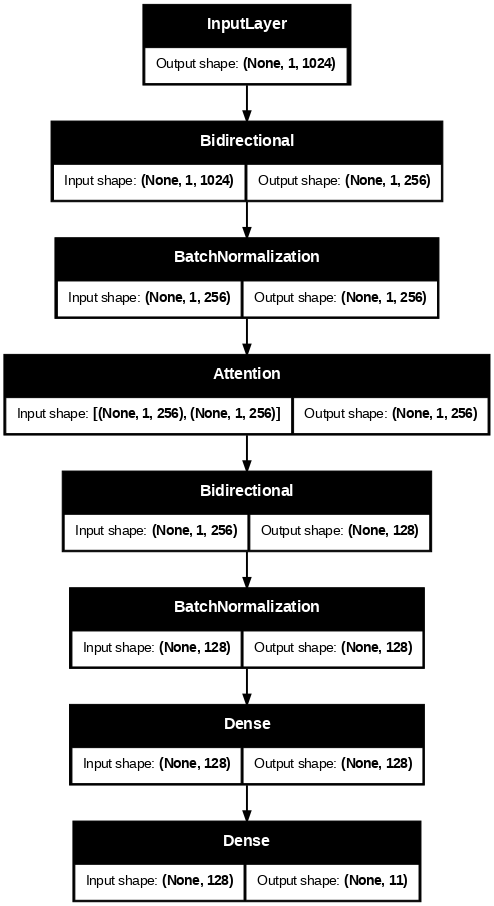

In [ ]:
plot_model(model, to_file='class1_model.png', show_shapes=True, dpi=70)

In [351]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


history = model.fit(X_train_reshaped, y_train_encoded, epochs=5000, batch_size=32,
                    validation_data=(X_test_reshaped, y_test_encoded),
                    callbacks=[reduce_lr, lr_scheduler, checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/5000
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9924 - loss: 0.0433
Epoch 1: val_accuracy improved from -inf to 0.68000, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9919 - loss: 0.0440 - val_accuracy: 0.6800 - val_loss: 2.0355 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0001009000000000001.
Epoch 2/5000
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9803 - loss: 0.0555
Epoch 2: val_accuracy did not improve from 0.68000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9808 - loss: 0.0557 - val_accuracy: 0.6800 - val_loss: 2.0491 - learning_rate: 1.0090e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020079999999999997.
Epoch 3/5000
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9945 - loss: 0.0428
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010040000051958486.

Epoch 3: val

Сохраним кодировщик, чтобы использовать его на backendе

In [ ]:
with open('../models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

Сохраним модель в формате ONNX

In [354]:
model.save('../models/class_failure_point_model.keras')

loaded_model = tf.keras.models.load_model('best_model.keras')

spec = (tf.TensorSpec((None, 1, X_train.shape[1]), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(loaded_model, input_signature=spec, opset=13)

with open("best_model.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

Оценим качество модели с помощью метрик

In [356]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('best_model.keras')

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_encoded, y_pred_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 943ms/step
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       1.00      0.90      0.95        10
           6       1.00      0.50      0.67         2
           8       0.80      0.80      0.80         5
          10       1.00      1.00      1.00         2
          11       0.00      0.00      0.00         1
          12       0.75      0.69      0.72        13
          13       0.91      1.00      0.95        10
          14       0.50      1.00      0.67         2
          15       0.00      0.00      0.00         1
          16       0.50      1.00      0.67         2

    accuracy                           0.78        50
   macro avg       0.54      0.57      0.53        50
weighted avg       0.78      0.78      0.77        50



## Обучение на самостоятельно выделенной обучающей выборке.

А теперь проведем полный цикл обучения на всех данных.

In [362]:
df_train = pd.read_csv('../data/df_train_balanced_by_failure_point.csv')
df = pd.read_csv('../data/data_balanced_by_failure_point.csv')

df_train = pd.concat([df_train, df], ignore_index=True)
df_train

Тема  \
0    Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...   
1                                Гарантийный ремонт Т2   
2       НК2-1404 v2 // Не работает зарядное устройство   
3               НК2-1404 // Не работает Wi-FI (Кашира)   
4    Сервер СР2-5422 // После обновления bios и bmc...   
..                                                 ...   
875                                            Ноутбук   
876                                            Ноутбук   
877                                            Ноутбук   
878                                            Ноутбук   
879                                            Ноутбук   

                                              Описание  \
0    Добрый день! \r\n Ноутбук СИЛА НК2-3404 - NTB4...   
1    Добрый день. \r\n Прошу произвести гарантийный...   
2                      Не работает зарядное устройство   
3                       На устройстве не работает WiFi   
4    Добрый день!\r\nПосле обновления bios и bmc в ...   
..                                                 ...   
875  Неполадки с установкой драйверов и регулярные ...   
876  Неполадки с установкой драйверов, частые перез...   
877  Неудачные попытки установки драйверов, частые ...   
878  Неполадки с установкой драйверов и регулярные ...   
879  Неполадки с установкой драйверов, частые перез...   

                                       Точка отказа Серийный номер  \
0                                           Матрица     C223091505   
1                                        Вентилятор     C223014726   
2                                      Блок питания     C223100822   
3                                     Wi-fi антенна     C223101179   
4                                        Вентилятор     D251110031   
..                                              ...            ...   
875  Проблемы с установкой программного обеспечения     C111120125   
876                                  Неустановленна     С111120125   
877                        Неустановленные драйверы     С111120125   
878  Проблемы с установкой программного обеспечения     C111120125   
879                                  Неустановленна     С111120125   

    Тип оборудования  
0            Ноутбук  
1            Ноутбук  
2            Ноутбук  
3            Ноутбук  
4             Сервер  
..               ...  
875          Ноутбук  
876          Ноутбук  
877          Ноутбук  
878          Ноутбук  
879          Ноутбук  

[880 rows x 5 columns]

In [363]:
df_train = df_train.drop_duplicates()

df_train = df_train.reset_index(drop=True)

df_train

Тема  \
0    Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...   
1                                Гарантийный ремонт Т2   
2       НК2-1404 v2 // Не работает зарядное устройство   
3               НК2-1404 // Не работает Wi-FI (Кашира)   
4    Сервер СР2-5422 // После обновления bios и bmc...   
..                                                 ...   
587                                            Ноутбук   
588                                            Ноутбук   
589                                            Ноутбук   
590                                            Ноутбук   
591                                            Ноутбук   

                                              Описание  \
0    Добрый день! \r\n Ноутбук СИЛА НК2-3404 - NTB4...   
1    Добрый день. \r\n Прошу произвести гарантийный...   
2                      Не работает зарядное устройство   
3                       На устройстве не работает WiFi   
4    Добрый день!\r\nПосле обновления bios и bmc в ...   
..                                                 ...   
587  Не удается корректно установить последние обно...   
588  Неудачные попытки установки драйверов и частые...   
589  Проблемы с настройкой драйверов и частые сбои ...   
590  Неполадки с установкой драйверов и регулярные ...   
591  Неполадки с установкой драйверов и частые ошиб...   

                                          Точка отказа Серийный номер  \
0                                              Матрица     C223091505   
1                                           Вентилятор     C223014726   
2                                         Блок питания     C223100822   
3                                        Wi-fi антенна     C223101179   
4                                           Вентилятор     D251110031   
..                                                 ...            ...   
587                                       Неопределена     С111120125   
588     Проблемы с установкой программного обеспечения     С111120125   
589  Неудачные попытки установки программного обесп...     C111120125   
590     Проблемы с установкой программного обеспечения     C111120125   
591     Проблемы с установкой программного обеспечения     C111120125   

    Тип оборудования  
0            Ноутбук  
1            Ноутбук  
2            Ноутбук  
3            Ноутбук  
4             Сервер  
..               ...  
587          Ноутбук  
588          Ноутбук  
589          Ноутбук  
590          Ноутбук  
591          Ноутбук  

[592 rows x 5 columns]

In [365]:
df_train['Тема_Описание'] = df_train['Тема'] + ' ' + df_train['Описание']

df_train = df_train.drop(columns=['Тип оборудования', 'Серийный номер', 'Тема', 'Описание'])

df_train

Точка отказа  \
0                                              Матрица   
1                                           Вентилятор   
2                                         Блок питания   
3                                        Wi-fi антенна   
4                                           Вентилятор   
..                                                 ...   
587                                       Неопределена   
588     Проблемы с установкой программного обеспечения   
589  Неудачные попытки установки программного обесп...   
590     Проблемы с установкой программного обеспечения   
591     Проблемы с установкой программного обеспечения   

                                         Тема_Описание  
0    Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...  
1    Гарантийный ремонт Т2 Добрый день. \r\n Прошу ...  
2    НК2-1404 v2 // Не работает зарядное устройство...  
3    НК2-1404 // Не работает Wi-FI (Кашира) На устр...  
4    Сервер СР2-5422 // После обновления bios и bmc...  
..                                                 ...  
587  Ноутбук Не удается корректно установить послед...  
588  Ноутбук Неудачные попытки установки драйверов ...  
589  Ноутбук Проблемы с настройкой драйверов и част...  
590  Ноутбук Неполадки с установкой драйверов и рег...  
591  Ноутбук Неполадки с установкой драйверов и час...  

[592 rows x 2 columns]

In [366]:
import pandas as pd
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

texts = df_train['Тема_Описание'].tolist()

batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**batch_dict)

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

embeddings = F.normalize(embeddings, p=2, dim=1)

In [367]:
embeddings_df = pd.DataFrame(embeddings.numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

df_train = pd.concat([df_train.drop(columns=['Тема_Описание']), embeddings_df], axis=1)

df_train

Точка отказа  embedding_0  \
0                                              Матрица     0.021880   
1                                           Вентилятор     0.000710   
2                                         Блок питания     0.014018   
3                                        Wi-fi антенна     0.002344   
4                                           Вентилятор     0.011309   
..                                                 ...          ...   
587                                       Неопределена     0.015528   
588     Проблемы с установкой программного обеспечения     0.003834   
589  Неудачные попытки установки программного обесп...     0.008712   
590     Проблемы с установкой программного обеспечения     0.009435   
591     Проблемы с установкой программного обеспечения     0.007668   

     embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       0.000266    -0.016779    -0.032101     0.041302    -0.003823   
1       0.018861    -0.022094    -0.043200     0.027966    -0.013464   
2       0.016968    -0.022333    -0.050782     0.013659    -0.009213   
3       0.024181    -0.015709    -0.054320     0.018772     0.017711   
4      -0.000647    -0.044379    -0.037740     0.007516    -0.015195   
..           ...          ...          ...          ...          ...   
587     0.025270    -0.016087    -0.052016     0.016931     0.020181   
588     0.024011    -0.022316    -0.034936     0.018938     0.024209   
589     0.014353    -0.030886    -0.031564     0.019106     0.024951   
590     0.014924    -0.015486    -0.038700     0.025501     0.014645   
591     0.015323    -0.012873    -0.032599     0.025991     0.012167   

     embedding_6  embedding_7  embedding_8  ...  embedding_1014  \
0      -0.027679     0.128333     0.044932  ...       -0.014802   
1      -0.032622     0.095621     0.018601  ...       -0.014303   
2      -0.027521     0.100397     0.013647  ...       -0.007453   
3      -0.035852     0.084475     0.019610  ...       -0.009498   
4      -0.037206     0.093387     0.043190  ...       -0.008127   
..           ...          ...          ...  ...             ...   
587    -0.021645     0.107986     0.041346  ...       -0.010911   
588    -0.028836     0.097090     0.034441  ...       -0.001761   
589    -0.040639     0.103153     0.036582  ...       -0.008282   
590    -0.032334     0.097988     0.037188  ...       -0.005498   
591    -0.033382     0.094385     0.026955  ...       -0.007306   

     embedding_1015  embedding_1016  embedding_1017  embedding_1018  \
0         -0.049298       -0.013734       -0.022491        0.007650   
1         -0.052902       -0.008643       -0.017012        0.002425   
2         -0.035183        0.000590       -0.022955        0.004155   
3         -0.056558       -0.001000       -0.021705        0.012198   
4         -0.032145        0.001245       -0.001029       -0.005868   
..              ...             ...             ...             ...   
587       -0.040609       -0.003587        0.014330        0.010351   
588       -0.047425       -0.019459       -0.006309        0.003271   
589       -0.041935       -0.032330       -0.008372        0.004254   
590       -0.043723       -0.019379       -0.004451        0.000158   
591       -0.046922       -0.017623       -0.010843       -0.002267   

     embedding_1019  embedding_1020  embedding_1021  embedding_1022  \
0          0.028164        0.025039       -0.026492       -0.050613   
1          0.043361        0.036186       -0.035695       -0.020255   
2          0.060856        0.031812       -0.021440       -0.045939   
3          0.043378        0.010904       -0.014733       -0.038842   
4          0.023222        0.024029       -0.018698        0.000710   
..              ...             ...             ...             ...   
587        0.045806        0.026553       -0.031658       -0.033116   
588        0.035474        0.030171       -0.033178       -0.018842   
589        0.046877        

In [368]:
df_train = df_train[df_train['Точка отказа'] != 'Консультация']

df_train

Точка отказа  embedding_0  \
0                                              Матрица     0.021880   
1                                           Вентилятор     0.000710   
2                                         Блок питания     0.014018   
3                                        Wi-fi антенна     0.002344   
4                                           Вентилятор     0.011309   
..                                                 ...          ...   
587                                       Неопределена     0.015528   
588     Проблемы с установкой программного обеспечения     0.003834   
589  Неудачные попытки установки программного обесп...     0.008712   
590     Проблемы с установкой программного обеспечения     0.009435   
591     Проблемы с установкой программного обеспечения     0.007668   

     embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0       0.000266    -0.016779    -0.032101     0.041302    -0.003823   
1       0.018861    -0.022094    -0.043200     0.027966    -0.013464   
2       0.016968    -0.022333    -0.050782     0.013659    -0.009213   
3       0.024181    -0.015709    -0.054320     0.018772     0.017711   
4      -0.000647    -0.044379    -0.037740     0.007516    -0.015195   
..           ...          ...          ...          ...          ...   
587     0.025270    -0.016087    -0.052016     0.016931     0.020181   
588     0.024011    -0.022316    -0.034936     0.018938     0.024209   
589     0.014353    -0.030886    -0.031564     0.019106     0.024951   
590     0.014924    -0.015486    -0.038700     0.025501     0.014645   
591     0.015323    -0.012873    -0.032599     0.025991     0.012167   

     embedding_6  embedding_7  embedding_8  ...  embedding_1014  \
0      -0.027679     0.128333     0.044932  ...       -0.014802   
1      -0.032622     0.095621     0.018601  ...       -0.014303   
2      -0.027521     0.100397     0.013647  ...       -0.007453   
3      -0.035852     0.084475     0.019610  ...       -0.009498   
4      -0.037206     0.093387     0.043190  ...       -0.008127   
..           ...          ...          ...  ...             ...   
587    -0.021645     0.107986     0.041346  ...       -0.010911   
588    -0.028836     0.097090     0.034441  ...       -0.001761   
589    -0.040639     0.103153     0.036582  ...       -0.008282   
590    -0.032334     0.097988     0.037188  ...       -0.005498   
591    -0.033382     0.094385     0.026955  ...       -0.007306   

     embedding_1015  embedding_1016  embedding_1017  embedding_1018  \
0         -0.049298       -0.013734       -0.022491        0.007650   
1         -0.052902       -0.008643       -0.017012        0.002425   
2         -0.035183        0.000590       -0.022955        0.004155   
3         -0.056558       -0.001000       -0.021705        0.012198   
4         -0.032145        0.001245       -0.001029       -0.005868   
..              ...             ...             ...             ...   
587       -0.040609       -0.003587        0.014330        0.010351   
588       -0.047425       -0.019459       -0.006309        0.003271   
589       -0.041935       -0.032330       -0.008372        0.004254   
590       -0.043723       -0.019379       -0.004451        0.000158   
591       -0.046922       -0.017623       -0.010843       -0.002267   

     embedding_1019  embedding_1020  embedding_1021  embedding_1022  \
0          0.028164        0.025039       -0.026492       -0.050613   
1          0.043361        0.036186       -0.035695       -0.020255   
2          0.060856        0.031812       -0.021440       -0.045939   
3          0.043378        0.010904       -0.014733       -0.038842   
4          0.023222        0.024029       -0.018698        0.000710   
..              ...             ...             ...             ...   
587        0.045806        0.026553       -0.031658       -0.033116   
588        0.035474        0.030171       -0.033178       -0.018842   
589        0.046877        

In [369]:
X_train = df_train.drop(columns=['Точка отказа'])
y_train = df_train['Точка отказа']

X_test = df_test.drop(columns=['Точка отказа'])
y_test = df_test['Точка отказа']

In [370]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [371]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [372]:
def cyclical_learning_rate(epoch, lr, min_lr=1e-6, max_lr=1e-3, step_size=10):
    # Определяем текущий цикл
    cycle = math.floor(1 + epoch / (2 * step_size))
    # Определяем значение x для текущего шага
    x = abs(epoch / step_size - 2 * cycle + 1)
    # Вычисляем новую скорость обучения
    new_lr = min_lr + (max_lr - min_lr) * max(0, (1 - x))
    return new_lr

# Создаем планировщик для изменения скорости обучения с использованием циклической скорости
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cyclical_learning_rate(epoch, lr), verbose=1)

# Определяем входной слой сети с заданной формой
input_layer = Input(shape=(1, X_train.shape[1]))

# Добавляем двунаправленный LSTM слой с 128 нейронами и возвращающим последовательности
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
# Нормализуем выходы LSTM
lstm_out = BatchNormalization()(lstm_out)
# Применяем Dropout для регуляризации
lstm_out = Dropout(0.5)(lstm_out)

# Применяем механизм внимания к выходу LSTM
attention_out = Attention()([lstm_out, lstm_out])

# Добавляем второй двунаправленный LSTM слой с 64 нейронами
lstm_out2 = Bidirectional(LSTM(64))(attention_out)
# Нормализуем выходы второго LSTM
lstm_out2 = BatchNormalization()(lstm_out2)
# Применяем Dropout для регуляризации
lstm_out2 = Dropout(0.5)(lstm_out2)

# Добавляем полносвязный слой с 128 нейронами и активацией ReLU с L2 регуляризацией
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out2)
# Применяем Dropout для регуляризации
dense_out = Dropout(0.5)(dense_out)

# Определяем выходной слой с количеством нейронов, равным количеству классов, с активацией softmax
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_out)

# Создаем модель с заданными входами и выходами
model = Model(inputs=input_layer, outputs=output_layer)
     

In [ ]:
# Создаем объект для сохранения лучшей модели на основе валидационной точности
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Имя файла, в который будет сохранена модель
    monitor='val_accuracy',   # Метрика для отслеживания (валидационная точность)
    save_best_only=True,      # Сохранять только лучшую модель
    mode='max',               # Режим, указывающий, что мы хотим максимизировать точность
    verbose=1                 # Уровень вывода информации о процессе сохранения модели
)

# Компилируем модель с заданной функцией потерь, оптимизатором и метриками
model.compile(
    loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    optimizer='adam',                        # Оптимизатор Adam
    metrics=['accuracy']                     # Метрики, которые будут отслеживаться во время обучения
)

In [374]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])


history = model.fit(X_train_reshaped, y_train_encoded, epochs=5000, batch_size=32,
                    validation_data=(X_test_reshaped, y_test_encoded),
                    callbacks=[reduce_lr, lr_scheduler, checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/5000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0145 - loss: 5.7815
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.0145 - loss: 5.7778 - val_accuracy: 0.0000e+00 - val_loss: 4.7574 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0001009000000000001.
Epoch 2/5000
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0129 - loss: 5.7409 
Epoch 2: val_accuracy improved from 0.00000 to 0.18000, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0137 - loss: 5.7291 - val_accuracy: 0.1800 - val_loss: 4.7472 - learning_rate: 1.0090e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00020079999999999997.
Epoch 3/5000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0343 - loss: 5.3554
Epoch 3: val_accuracy improved from 0.18000 

In [ ]:
with open('../models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [377]:
model.save('../models/class_failure_point_model.keras')

loaded_model = tf.keras.models.load_model('best_model.keras')

spec = (tf.TensorSpec((None, 1, X_train.shape[1]), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(loaded_model, input_signature=spec, opset=13)

with open("../models/best_model.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())